# Visualizing crime trends in St. Louis city

This notebook illustrates various patterns for crimes reported in St. Louis, MO between the years 2008-2016.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
%matplotlib notebook

## Dataframe manipulation

We first load the crime data (cleaned using the `stl_crime_cleaning.ipynb` notebook, and manipulate it to streamline the visualizations. 

In [6]:
crimedf = pd.read_pickle('cleaned_data/crimedf.pkl')

# dictionary to convert neighbhorhoods to/from numbers
hooddict = {'Carondelet': 1, 'Patch': 2, 'Holly Hills': 3, 'Boulevard Heights': 4, 'Bevo Mill': 5, 'Princeton Heights': 6, 'South Hampton': 7, 'St. Louis Hills': 8, 'Lindenwood Park': 9, 'Ellendale': 10, 'Clifton Heights': 11, 'The Hill': 12, 'Southwest Garden': 13, 'North Hampton': 14, 'Tower Grove South': 15, 'Dutchtown': 16, 'Mount Pleasant': 17, 'Marine Villa': 18, 'Gravois Park': 19, 'Kosciusko': 20, 'Soulard': 21, 'Benton Park': 22, 'McKinley Heights': 23, 'Fox Park': 24, 'Tower Grove East': 25, 'Compton Heights': 26, 'Shaw': 27, 'Botanical Heights (formerly McRee Town)': 28, 'Tiffany': 29, 'Benton Park West': 30, 'The Gate District': 31, 'Lafayette Square': 32, 'Peabody, Darst, Webbe': 33, 'La Salle': 34, 'Downtown': 35, 'Downtown West': 36, 'Midtown': 37, 'Central West End': 38, 'Forest Park Southeast': 39, 'Kings Oak': 40, 'Cheltenham': 41, 'Clayton-Tamm': 42, 'Franz Park': 43, 'Hi-Pointe': 44, 'Wydown-Skinker': 45, 'Skinker-DeBaliviere': 46, 'DeBaliviere Place': 47, 'West End': 48, 'Visitation Park': 49, 'Wells-Goodfellow': 50, 'Academy': 51, 'Kingsway West': 52, 'Fountain Park': 53, 'Lewis Place': 54, 'Kingsway East': 55, 'The Greater Ville': 56, 'The Ville': 57, 'Vandeventer': 58, 'JeffVanderLou': 59, 'St. Louis Place': 60, 'Carr Square': 61, 'Columbus Square': 62, 'Old North St. Louis': 63, 'Near North Riverfront': 64, 'Hyde Park': 65, 'College Hill': 66, 'Fairground Neighborhood': 67, "O'Fallon": 68, 'Penrose': 69, 'Mark Twain-I-70 Industrial': 70, 'Mark Twain': 71, 'Walnut Park East': 72, 'North Point': 73, 'Baden': 74, 'Riverview': 75, 'Walnut Park West': 76, 'Covenant Blu-Grand Center': 77, 'Hamilton Heights': 78, 'North Riverfront': 79, 'Carondelet Park': 80, 'Tower Grove Park': 81, 'Forest Park': 82, 'Fairgrounds Park': 83, 'Penrose Park': 84, 'Calvary-Bellefontaine Cemetaries': 86}
inv_hooddict = {v: k for k, v in hooddict.items()}

hoodpopdf = pd.read_pickle('cleaned_data/hoodpopdf.pkl')
hoodpopdf['Name'] = hoodpopdf['Neighborhood'].replace(inv_hooddict)
hoodpopdict = hoodpopdf.set_index('Name')['Neighborhood']
hoodpopdf = hoodpopdf[~(hoodpopdf['Name']=="O'Fallon Park")]

crimedf['Robbery'] = 0
crimedf.loc[crimedf['Crime'].str[0:2] == '03', 'Robbery'] = 1

crimedf['Hour']=crimedf['Hour'].astype(float)
crimedf['Minute']=crimedf['Minute'].astype(float)
crimedf['time_of_day'] = crimedf['Hour'].astype(float) + crimedf['Minute'].astype(float)/60
crimedf['day_of_year'] = crimedf['Date'].dt.dayofyear.astype(float)
crimedf['time_of_day'] = crimedf['time_of_day']-7
crimedf.loc[crimedf['time_of_day']<0,'time_of_day'] = crimedf.loc[crimedf['time_of_day']<0,'time_of_day'] + 24
crimedf['ZHVI'] = crimedf['ZHVI'].astype(float)
crimedfrobbery = crimedf[(crimedf['Robbery']==1)]

## Most common times of day/year for robberies

The plot below demonstrated a strong relationship between the frequency of robberies and the time of day/year.  In fact, most robberies occur in the hours following sunset.  

<IPython.core.display.Javascript object>


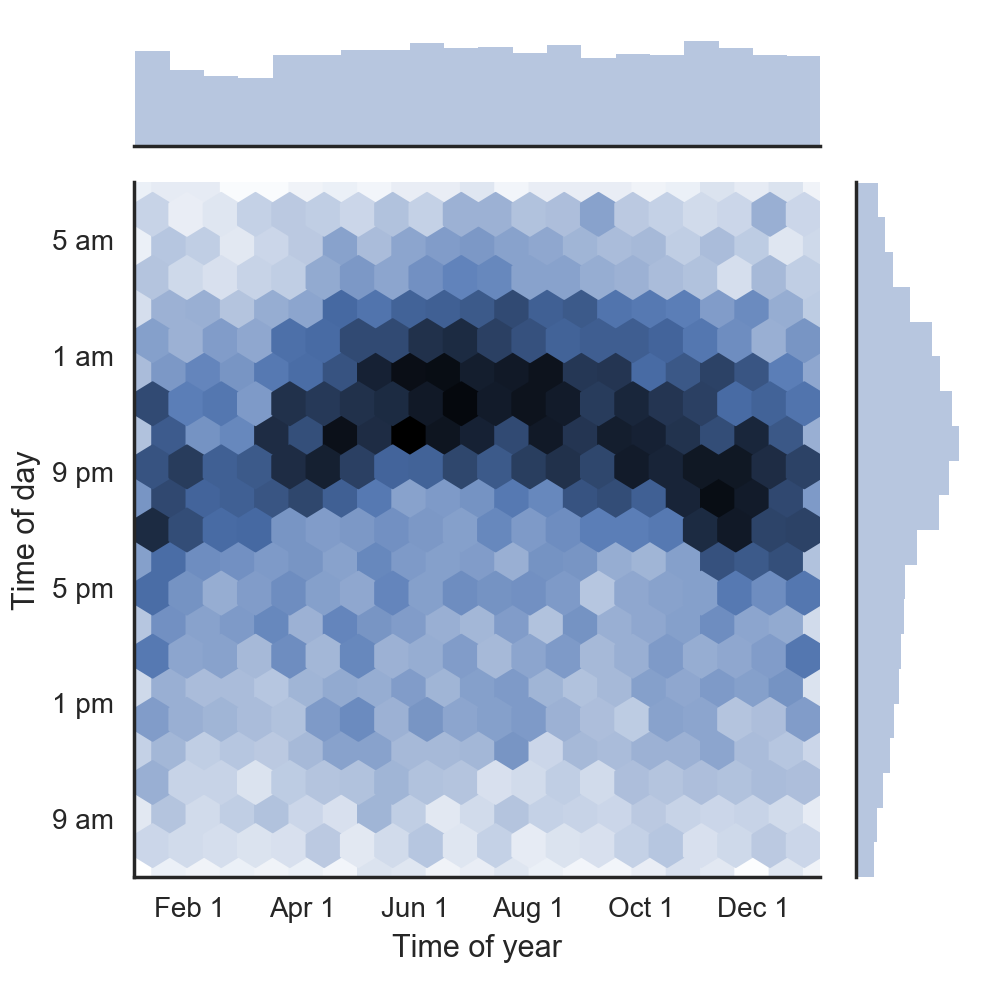

In [4]:
sbp = sns.jointplot(crimedfrobbery.day_of_year, crimedfrobbery.time_of_day, kind='hex', size=5, stat_func=None, space=1/3, gridsize=20, marginal_kws={"bins": 20});
sbp.set_axis_labels('Time of year', 'Time of day')
sbp.ax_joint.set_yticks([2, 6, 10, 14, 18, 22])
sbp.ax_joint.set_xticks([30, 90, 150, 210, 270, 330])
sbp.ax_joint.set_yticklabels(['9 am','1 pm','5 pm','9 pm','1 am','5 am'])
sbp.ax_joint.set_xticklabels(['Feb 1','Apr 1','Jun 1','Aug 1','Oct 1','Dec 1'])
sbp.ax_joint.set_xlim([0, 365])
sbp.ax_joint.set_ylim([0, 24])
sns.set(style="white", color_codes=True)
sbp.savefig("robbery_tod_vs_toy.pdf", bbox_inches='tight')

## Crimes and neighborhood economy

The number of crimes per capita in St. Louis neighborhoods depends strongly on economic factors, which vary by neighborhood.  In the plot below, each color corresonds to a different neighborhood, and the size of the markers indicates the population of the neighborhood.

<IPython.core.display.Javascript object>


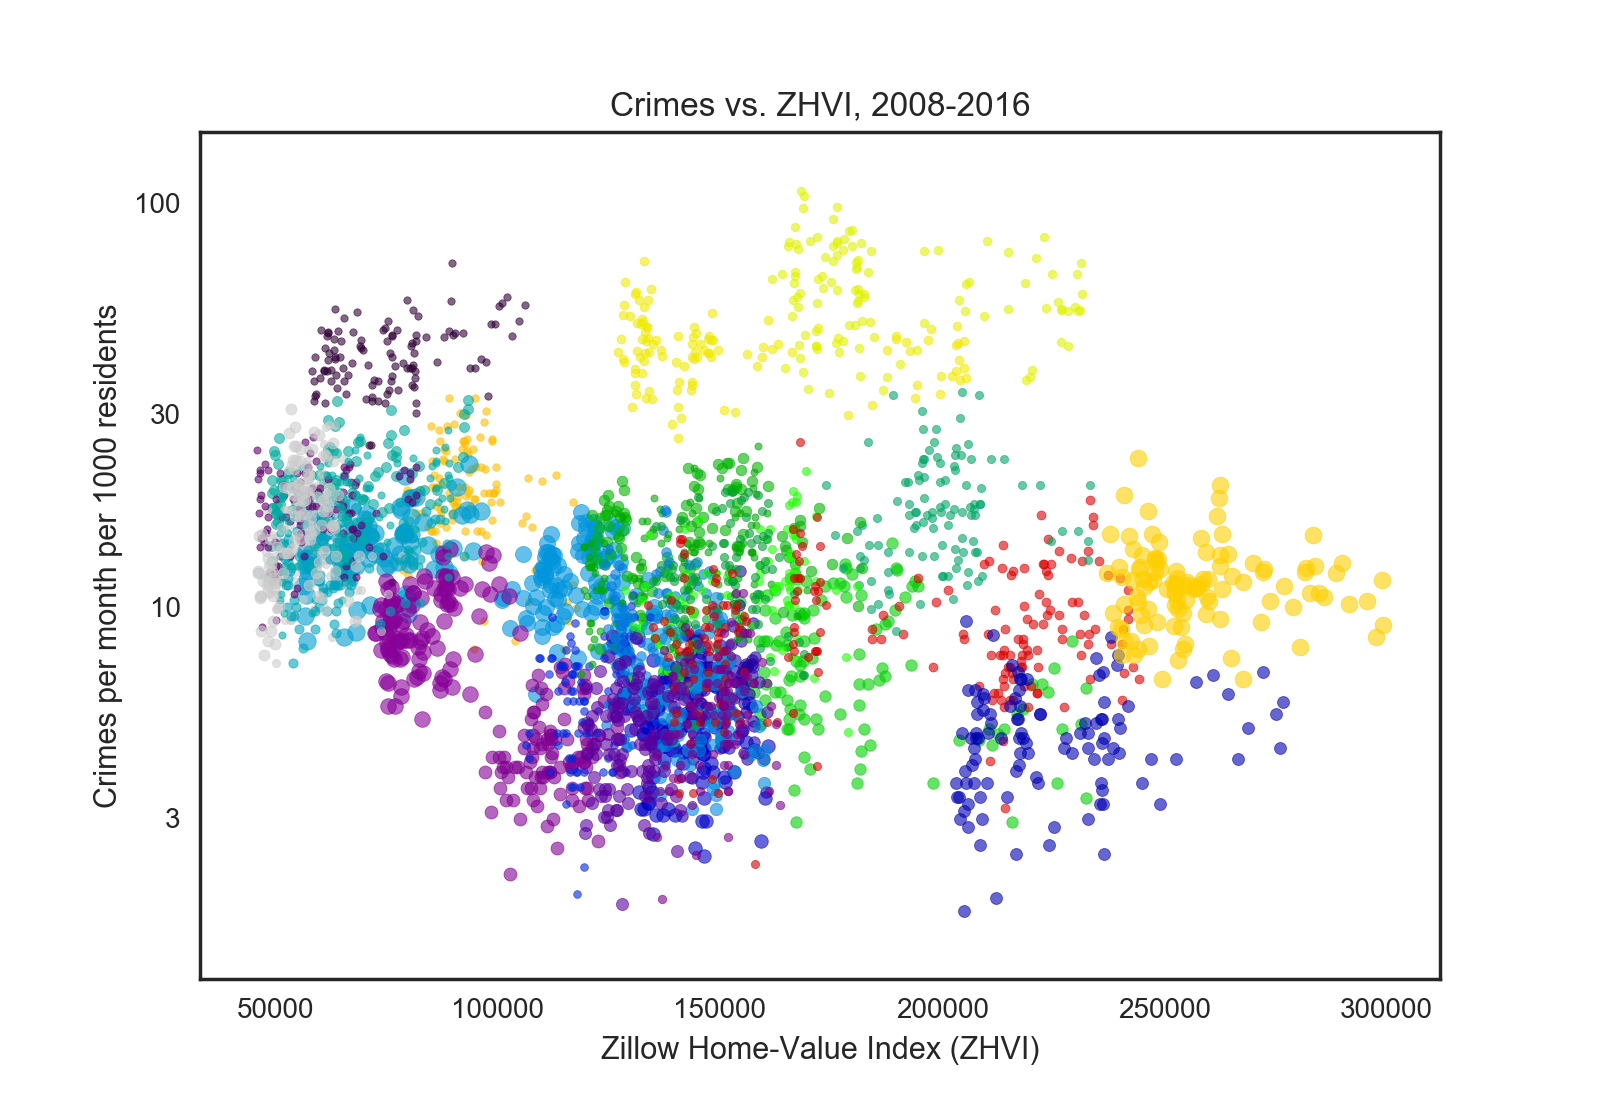

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for n in crimedf['Neighborhood'].unique():
    if n in hoodpopdf['Neighborhood'].unique():
        tmp = crimedf[crimedf['Neighborhood']==n].groupby(['Year','Month']).agg({'ZHVI':'mean', 'Violent': 'count'})
        pop = hoodpopdf[hoodpopdf['Neighborhood']==n]['Population'].as_matrix()[0]
        x = tmp['ZHVI'].values
        y = tmp['Violent'].values
        if pop > 2500:
            plt.scatter(x, y/pop*1000, s=pop/400, c=plt.cm.nipy_spectral(n*5), alpha=0.6)
 
ax.set_xlabel('Zillow Home-Value Index (ZHVI)')
ax.set_ylabel('Crimes per month per 1000 residents')
ax.set_title('Crimes vs. ZHVI, 2008-2016')
ax.set_yscale('log')
ax.set_yticks([1,3,10,30,100])
ax.set_yticklabels([1,3,10,30,100])
ax.set_ylim([1.2, 150])
ax.set_xlim([33000, 312000])
plt.savefig("crime_vs_zhvi.pdf", bbox_inches='tight')
